<a href="https://colab.research.google.com/github/novad/ADS_example/blob/master/ADS_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder-based ADS

This notebook describes an adaptation of the autoencoder ADS of my thesis work, carried out with the new dataset.

There are four main steps to follow to implement the ADS:
1. [Preprocessing](#preprocessing): Prepare the data to train and use the neural network.
2. [Modelling](#model): Defining and training the autoencoder.
3. [Anomaly scores](#scores): Computing the anomaly scores on non-anomalous data.
4. [Detecting anomalies](#anomaly): Comparing the scores of anomalous and normal sequences.


We begin by loading the needed modules and loading the dataset file.

In [1]:
# Imports and constants
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import (classification_report, confusion_matrix, auc,
                             roc_curve, recall_score, precision_recall_curve, precision_recall_fscore_support)

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, GRU
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import backend as K
from keras.layers import Lambda

import tensorflow as tf

VERBOSE = 1  # Set to 0 to hide progress bars when training and predicting

# Dataset file names
FILE_PATH_TRAINING = 'SWaT_Dataset_Normal_v1.csv'
FILE_PATH_ANOM = 'SWaT_Dataset_Attack_v0.csv'

Using TensorFlow backend.


## Loading the training dataset
Load the file specified in FILE_PATH_TRAINING as the training dataset.

In [0]:
def load_file(filename, nrows=None, skiprows=0):
    df = pd.read_csv(filename, header=0, sep=';', decimal=",", nrows=nrows, skiprows=[i for i in range(1,skiprows)])
    # Some column names have leading spaces, remove them
    df.columns = df.columns.str.replace(' ', '') 
  
    # This dataset is generated from 6 different data generating mechanisms. 
    # We will only use one of them for this example.
    df = df[['FIT101', 'FIT201', 'FIT301', 'FIT401', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'FIT601', 'Normal/Attack']]
    return df

In [0]:
# Loading only a subset of samples for this example
# Total number of rows in the file is 400k+
df = load_file(FILE_PATH_TRAINING, nrows=100000)
# Drop the normal-attack column, in the training set every sample is 'normal'
df.drop(['Normal/Attack'], axis=1, inplace=True)

<a id='preprocessing'></a>
# 1) Preprocessing 
Preprocessing the data depends heavily on the nature of the dataset, in this notebook we scale the results into the [0-1] range as in the CAN ADS.
The caveat here is that the sample we use must be significant enough to scale the data accurately.

Alternatively, we can use StandardScaler to remove the mean and scale to a unit variance. However, if we do that, a `binary_crosentropy` loss function is not suitable for training our autoencoder model (as win the CAN ADS). In that case, one alternative is using the mean square error (mse) loss function instead.

PCA could also be applied, but that would also imply that changes of the model are needed. In this case, a simpler model as exposed by Malhotra et al. could be used (see [https://arxiv.org/abs/1607.00148])

In [0]:
# Scaling the data
scaler = preprocessing.MinMaxScaler()
scaler.fit(df.values)

X = scaler.transform(df.values)

# TODO: save scaler into a file

Create the training and validation datasets.

In [0]:
SPLIT = 0.1  # 10% used for validation

X_train, X_val = train_test_split(X, test_size=SPLIT, shuffle=False)
n_features = X_train.shape[1]  # number of features, or variables

### Building the data sequences
The autoencoder receives as input *sequences* of data, so we must format the input as sequences of continuous observations.
From a set of observations $x_0, x_1, x_2, \dots$ we build a set of sequences with fixed timesteps.

In the thesis work the timesteps were set to 20, so the sequences will be built as:
$$x_0, x_1, \dots, x_{19}$$
$$x_{20}, x_{21}, \dots, x_{39}$$
$$x_{40}, x_{31}, \dots, x_{59}$$
$$\dots$$

*Note:* The number of timesteps is also a hyperparameter that can be tuned according to the dataset and the needs of the ADS.

In the CAN ADS the autoencoder receives as an input a set of reversed sequences, that is:
$$x_{19}, x_{18}, \dots, x_{0}$$
$$x_{39}, x_{38}, \dots, x_{20}$$
$$x_{59}, x_{58}, \dots, x_{40}$$
$$\dots$$

We define a function that builds the sequences, and for convenience, returns both the sequence and its reversed version.

In [0]:
TIME_STEPS = 20

def build_data_sequences(data, timesteps=TIME_STEPS):
    """
    Function that creates the data sequences for the autoencoder.
    Receives as an input a data x_0, x_1, x_2, ...
    Returns a set of continuous sequences in an array of shape (n - input_steps, timesteps, n_features), 
    and additionally returns sequences in reversed order.
    """
    data_x = []
    for i in range(len(data)-timesteps):
        data_x.append(data[i:i + timesteps])
    seq = np.array(data_x)
    seq_reversed = seq[::,::-1]   # same as seq but reversed, it is a view rather than a new array
    return seq, seq_reversed

In [0]:
# Training data sequences
(xtrain, xtrain_reversed) = build_data_sequences(X_train)

# Validation dataset for training
(xval, xval_reversed) = build_data_sequences(X_val)

____
<a id='model'></a>
# 2) Defining and training the Autoencoder

In this section we define the model structure and train the autoencoder with the dataset we have loaded.

The model hypermarameters and structure are the same as in the CAN ADS work, for this dataset a new hyperparameter search process could be carried out to improve performance.

As noted before, the input data is assumed to be in the [0-1] range as in CAN. If the data is not scaled using MinMaxScaler, but instead StandardScaler, the loss function would have to be modified. Otherwise, negative loss values would occur. 'mse' (mean squared error) could be an alternative loss function.

In [0]:
## Neural Network model Hyperparameters
HYP_DENSE_UNITS = 256
HYP_LSTM_UNITS = 128
HYP_DROPOUT = 0.2  # dropout probability
HYP_REINJECTED_PREDICTIONS = 20  # number of predictions to be re-injected to the decoder input during training

# Training hyperparameters
HYP_LOSS_FUNCTION = 'binary_crossentropy'
HYP_OPTIMIZER = 'adam'
HYP_BATCH_SIZE = 128
HYP_EPOCHS = 50

def init_autoencoder(n_features):
    """ Define the autoencoder model """
    # Encoder
    encoder_input = Input(shape=(None, n_features))
    encoder_dense = Dense(HYP_DENSE_UNITS, activation="tanh", name='encoder_dense')(encoder_input)
    enc_dropout = Dropout(HYP_DROPOUT)(encoder_dense)
    
    encoder_lstm1 = LSTM(HYP_LSTM_UNITS, return_sequences=True, return_state=False,
                         name="encoder_lstm1")(enc_dropout)
    encoder_lstm2, state_h, state_c = LSTM(HYP_LSTM_UNITS, return_sequences=False, return_state=True,
                                           name="encoder_lstm2")(encoder_lstm1)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(1, n_features))
    decoder_lstm_1 = LSTM(HYP_LSTM_UNITS, return_sequences=True, return_state=True, name="decoder_lstm1")
    decoder_lstm_2 = LSTM(HYP_LSTM_UNITS, return_sequences=True, return_state=False, name="decoder_lstm2")
    decoder_dense = Dense(n_features, activation="sigmoid", name="decoder_output")

    
    all_outputs = []
    inputs = decoder_inputs
    
    # Append previous decoder predictions 
    for _ in range(HYP_REINJECTED_PREDICTIONS):
        outputs_lstm1, state_h, state_c = decoder_lstm_1(inputs, initial_state=encoder_states)
        outputs_lstm2 = decoder_lstm_2(outputs_lstm1)
    
        outputs = decoder_dense(outputs_lstm2)
        all_outputs.append(outputs)
        inputs = outputs
        encoder_states = [state_h, state_c]

    # Concatenate all predictions
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

    return Model([encoder_input, decoder_inputs], decoder_outputs)

In [0]:
autoencoder_model = init_autoencoder(n_features)
autoencoder_model.name = 'AutoEncoder_model'

autoencoder_model.compile(loss=HYP_LOSS_FUNCTION, optimizer=HYP_OPTIMIZER)

### Training
The next step is training the autoencoder. 
The autoencoder receives a set of sequences as both input and target. 
In the CAN ADS, the input sequences are reversed and the target sequences are kept in the original order. Which sequence is reversed (input or target) does not alter the performance of the model. 

The loss values during training are saved using TensorBoard in order to study the progress during training.

Early stopping was included as a mechanism to avoid overfitting, if the validation loss does not improve after 10 epochs, training is stopped.


In [0]:
log_location = './logsDeepEncDec/' + autoencoder_model.name
tensorboard = TensorBoard(log_dir=log_location, histogram_freq=0, write_graph=True, write_images=True)

# The decoder must receive an input, so we set the decoder input value to 0's
decoder_input_data = np.zeros((xtrain.shape[0], 1, xtrain.shape[2]))
decoder_input_val = np.zeros((xval.shape[0], 1, xval.shape[2]))  # validation set

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=VERBOSE, mode='auto')

training_history = autoencoder_model.fit([xtrain_reversed, decoder_input_data], xtrain,
                                                  batch_size=HYP_BATCH_SIZE,
                                                  verbose=VERBOSE,
                                                  validation_data=([xval_reversed, decoder_input_val], xval),
                                                  callbacks=[earlystop, tensorboard],
                                                  epochs=HYP_EPOCHS
                                                  ).history

In [0]:
# Save the model to disk
autoencoder_model.save(autoencoder_model.name + ".h5")

Model Loss history during training

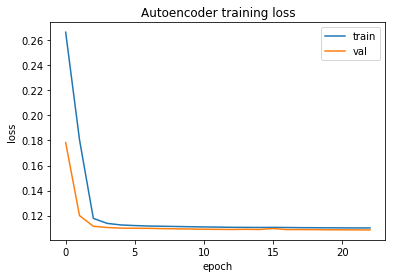

In [21]:
plt.plot(training_history['loss'])
plt.plot(training_history['val_loss'])
plt.title('Autoencoder training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');

It seems there is no overfitting going on. If it were some regularizer would be needed.

In [0]:
del xtrain, xtrain_reversed, xval, xval_reversed, df, X_train, X_val

_______
<a id='scores'></a>
# 3) Scores

At this point we have a model that can reconstruct sequences, now we must determine a metric (anomaly score) that tells us how normal/anomalous are the reconstruction errors of test sequences. 

With the trained autoencoder, we use a different dataset to compute the anomaly scores of 'normal', this follows a completely unsupervised learning approach. These scores tell us how the errors behave in normal traffic conditions.

As a brief recap, to find the scores we first compute the reconstruction errors of normal data. Then, we compute the mean and covariance matrix of such errors.
The anomaly score is then defined as the Mahalanobis distance between a reconstruction and the mean and covariance we computed before.

If you want to load the model we trained form disk, run:
`autoencoder_model = load_model(autoencoder_model.name + ".h5")`

In [0]:
def gaussian(data):
    """ Fit a multivariate gaussian of the given data """
    _mu = data.mean(axis=0)
    _sigma = (data-_mu).T @ (data-_mu) / data.shape[0]
    return _mu, _sigma

def anomaly_score(e, _mu, _sigma):
    """ 
    Compute the Mahalanobis distance between a given reconstruction error (e) 
    and the 'normal' errors distribution mu, sigma (i.e. mean and covariance matrix).
    """
    _a = np.dot((e - _mu).T, np.linalg.inv(_sigma))
    _a = np.dot(_a, (e-_mu))
    return _a

We compute the scores in a different dataset from the training one, so we begin by loading this new dataset. Here I selected some rows of the file after the ones used for training. 

In this notebook we used the first 100k rows for training, now we will use the following 50k for computing the scores
Naturally, the more data is used the scores would better fit the real distribution.

In [0]:
df = load_file(FILE_PATH_TRAINING, nrows=50000, skiprows=100000)
df.drop(['Normal/Attack'], axis=1, inplace=True)

# Scale the data
X = scaler.transform(df.values)

# Build the sequences
(x, x_reversed) = build_data_sequences(X)

In [70]:
reconstructions = autoencoder_model.predict([x_reversed, decoder_input_data], verbose=VERBOSE)

49980/49980 [==============================] - 80s 2ms/step


### Compute the reconstruction errors. 

The function to compute the reconstruction errors is the same we used to train our autoencoder. In this case it is a log loss function or also called binary cross entropy. If we use another loss function we must change how we compute the reconstruction errors. For example if using 'mse', the reconstruction error function would also be the mean square error, i.e. 

```
reconstruction_errors = np.mean(np.power(real_sequence - reconstructions, 2), axis=1)
```


In [0]:
epsilon_param = 1e-15

def reconstruction_error(y, y_hat):
    """ Simple method to compute prediction errors in arrays of sequences.
    Returns an ndarray of the same shape of the input with the log loss errors of y and y_hat.
    """
    assert (y.shape == y_hat.shape)
    errors = -1*(y*np.log(y_hat+epsilon_param)
                 + (1-y)*np.log(1-y_hat+epsilon_param))
    return errors

In [0]:
reconstruction_errors = reconstruction_error(x, reconstructions)

flattened_errors = np.reshape(reconstruction_errors,
                              (reconstruction_errors.shape[0]*reconstruction_errors.shape[1],
                               reconstruction_errors.shape[2]))

In [0]:

# Fitting Gaussian distribution
mu, sigma = gaussian(flattened_errors)

In [0]:
# Computing Scores, i.e. mahalanobis distance from our training observations
scores = [anomaly_score(f, mu, sigma) for f in flattened_errors]  

In [0]:
# Save scores results to disk
filepath = autoencoder_model.name + "_scores.pkl"
with open(filepath, 'wb') as out:
    results = {}
    results['mu'] = mu
    results['sigma'] = sigma
    pickle.dump(results, out, pickle.HIGHEST_PROTOCOL)

Now we have computed the anomaly scores of normal/non-anomalous data. Let's plot
the distribution of these scores.

In [0]:
def plot_distribution(data, title):
    mu, std = norm.fit(data)
    plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = title + "\nFit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)

    plt.show()

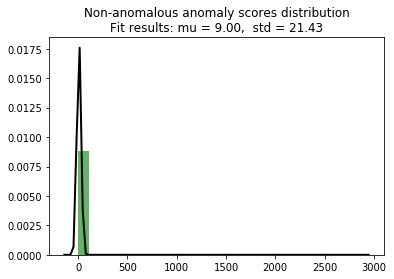

In [77]:
plot_distribution(scores, 'Non-anomalous anomaly scores distribution')

_______
<a id='anomaly'></a>
# 4) Anomaly detection

Now we test the anomaly scores in a dataset that contains anomalous data sequences.

First we load the dataset that contains anomalous data.

In [0]:
# First, load file with anomalies
df_anom = load_file(FILE_PATH_ANOM, nrows=20000)
df_anom.iloc[:, :-1] = scaler.transform(df_anom.iloc[:, :-1]) # we use iloc[:, :-1] to exclude the 'Normal/Attack' colum from the scaling part

### Create the test sequences

In this example, each test sequence consists of 300 non-overlapping sequences.

I dont know the nature behind the attack examples, or what aspects need to be evaluated, so I just create the test sequences from the dataset as they are saved in the file.

In [0]:
TEST_SEQUENCE_LENGTH = 300

n_samples = df_anom.shape[0]
n_features = int(df_anom.shape[1] - 1) # minus the 'Normal/attack' column
split = int(n_samples/TEST_SEQUENCE_LENGTH)

n = int(TEST_SEQUENCE_LENGTH*split)

anom_dataset = np.reshape(df_anom.values[:n], (split, TEST_SEQUENCE_LENGTH, n_features+1))

Now we define a function to compute the anomaly scores of the test sequences and return the anomaly scores of the sequence:

In [0]:
def get_sequence_anomaly_score(sequence, model, mu, sigma, verbose=0, window=TIME_STEPS):
    """Computes reconstruction errors for a single test sequence
    a (300 x p) sequence is first shaped into a (280 x 20 x p) set of sequences as a rolling window of size 20
    """
    _x = []
    # Create the overlapping sequence of data (sliding window with timesteps)
    for i in range(len(sequence) - window):
        _x.append(sequence[i:i + window])
        
    sequence_partitioned = np.array(_x) 
    seq_reversed = sequence_partitioned[::, ::-1]  # reverse the input sequence

    decoder_input = np.zeros((sequence_partitioned.shape[0], 1, sequence_partitioned.shape[2])) # 0 array for the decoder input
    
    reconstructions = model.predict([seq_reversed, decoder_input], verbose=verbose)
    reconstruction_errors = reconstruction_error(sequence_partitioned, reconstructions)

    # flatten the errors
    reconstruction_errors = np.reshape(reconstruction_errors, 
                                       (reconstruction_errors.shape[0]*reconstruction_errors.shape[1], 
                                        reconstruction_errors.shape[2]))
    anom_score = [anomaly_score(f, mu, sigma) for f in reconstruction_errors]
    
    return anom_score


### Checking the anomaly scores
This dataset includes examples of both anomalous and normal traffic.
For example, sequences 0 and 1 include only non-anomalous data.

Now we will compute the anomaly scores of these two test sequences, and plot their distribution.

In [0]:
def sequence_scores(anom_dataset, title=None, plot=False):
    autoencoder_input = anom_dataset[:,:-1]  # a normal test sequence, removing the 'Normal/attack label'
    scores = get_sequence_anomaly_score(autoencoder_input, autoencoder_model, mu, sigma, verbose=VERBOSE)
    if plot:
        plot_distribution(scores, title)
    
    return scores

280/280 [==============================] - 0s 2ms/step


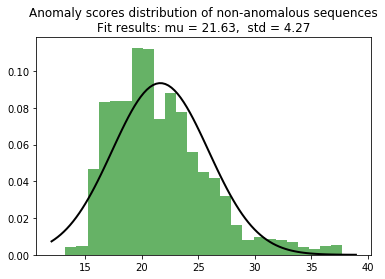

280/280 [==============================] - 0s 2ms/step


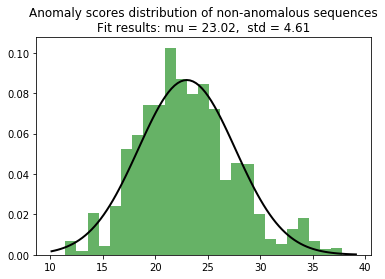

In [62]:
# Non-anomalous data
_= sequence_scores(anom_dataset[0],  title='Anomaly scores distribution of non-anomalous sequences', plot=True)
_= sequence_scores(anom_dataset[1],  title='Anomaly scores distribution of non-anomalous sequences', plot=True)

On the other hand, we can see that the distribution radically changes in presence of anomalous data.

Let's take as examples sequences 10 and 11:

280/280 [==============================] - 1s 2ms/step


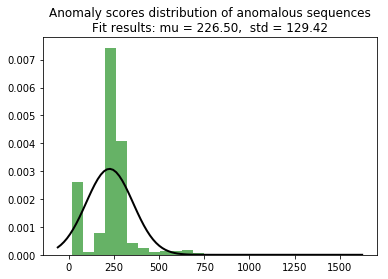

280/280 [==============================] - 0s 2ms/step


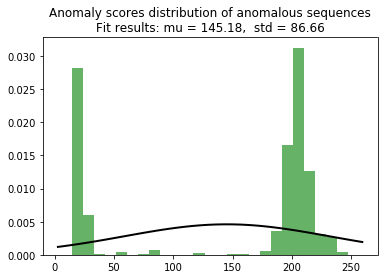

In [63]:
_= sequence_scores(anom_dataset[10],  title='Anomaly scores distribution of anomalous sequences', plot=True)
_= sequence_scores(anom_dataset[11],  title='Anomaly scores distribution of anomalous sequences', plot=True)

### Checking the detection performance

First, let's compute the anomaly scores of the test dataset and attach a label to identify whether or not the sequences have anomalous data or not.

We compute the anomaly score for each test sequence, which gives us the score for every observation in the sequence. Now we need to obtain a single score for an entire test sequence.
To obtain this score, as in the CAN ADS, we compute the 0.99 quantile of the sequence scores to get one of the highest value. Several other methods can be potential candidates to test a single anomaly score for every sequence, including simpler ones like analysing the standard deviation.

In [0]:
scores = []
y_true = []  # anomaly labels

# This is a slow process though, it takes about 1s per sequence.
for sequence in anom_dataset:
    seq_score = sequence_scores(sequence)
    scores.append(np.quantile(seq_score, 0.99))
    true_class = 0  # 0 for normal traffic, 1 for anomalous sequences
    if 'Attack' in sequence:
        true_class = 1
    y_true.append(true_class)
    
# Create a dataframe for the data sequences
df_scores = pd.DataFrame({'scores': scores, 'true': y_true})

### ROC curve and AUC

Now we can plot the ROC and compute the AUC of the anomaly detection tests. The ROC curve and AUC give us a general idea of the performance of the model. However, this is a heavily unbalanced dataset, so it would be more accurate to analyze directly precision and recall with respect to different threshold values (See sklearn function ```precision_recall_curve```).

From the `thresholds` variable obtained from calling `roc_curve`, we can find the score threshold that better suits the ADS needs, like minimizing false positives, maximizing the f1-score, etc. 

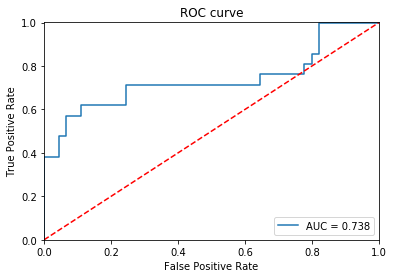

In [66]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(df_scores.true, df_scores.scores)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, label='AUC = %0.3f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.001])
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

From this preliminary result, the detection performance does not seem very good (even considering the AUC is not exactly an appropiate measure given the unbalanced dataset).

However, we do not know which physical process is presenting the anomaly/attack in the dataset. Theredore, we need to determine which label we have assigned as normal/attack corresponds to which physical process.

________
# Appendix: error distribution of all test data
Here we plot the error distribution of all the test data sequences for illustration purposes.

280/280 [==============================] - 0s 2ms/step


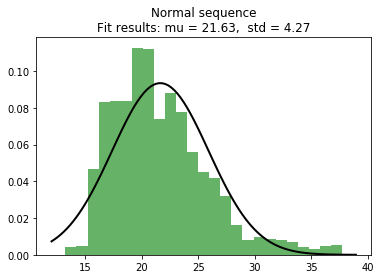

280/280 [==============================] - 0s 2ms/step


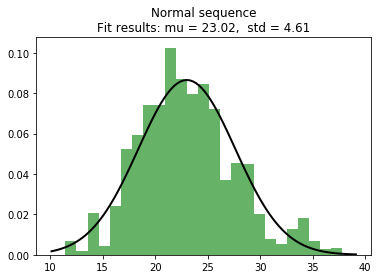

280/280 [==============================] - 0s 2ms/step


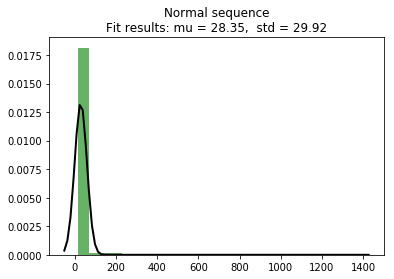

280/280 [==============================] - 0s 2ms/step


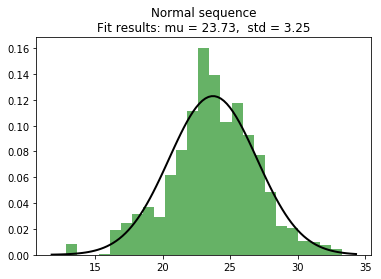

280/280 [==============================] - 1s 2ms/step


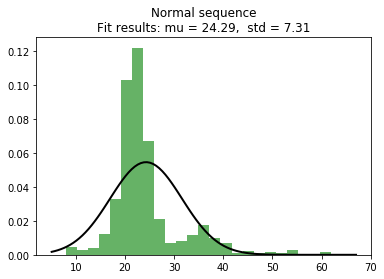

280/280 [==============================] - 0s 2ms/step


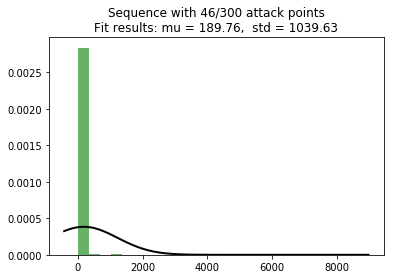

280/280 [==============================] - 0s 2ms/step


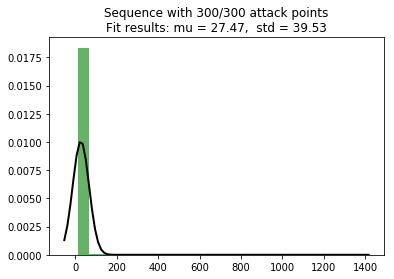

280/280 [==============================] - 1s 2ms/step


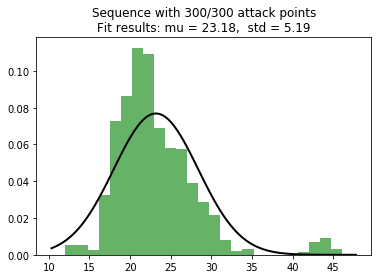

280/280 [==============================] - 1s 2ms/step


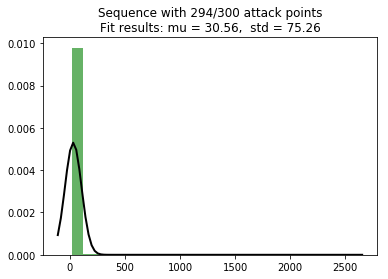

280/280 [==============================] - 1s 2ms/step


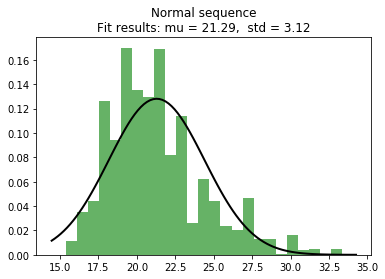

280/280 [==============================] - 0s 2ms/step


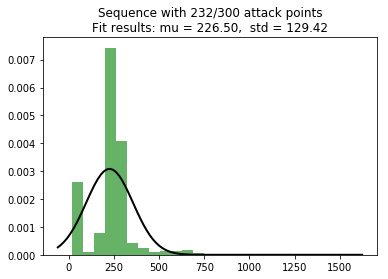

280/280 [==============================] - 0s 2ms/step


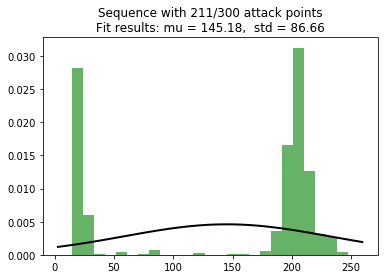

280/280 [==============================] - 0s 2ms/step


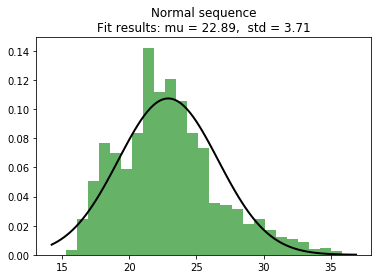

280/280 [==============================] - 0s 2ms/step


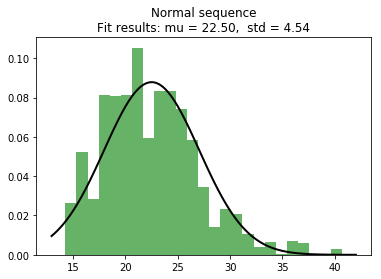

280/280 [==============================] - 0s 2ms/step


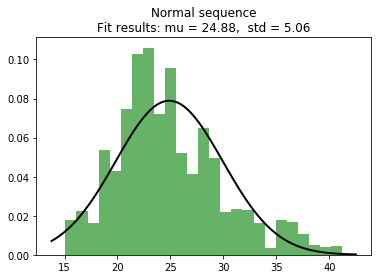

280/280 [==============================] - 1s 2ms/step


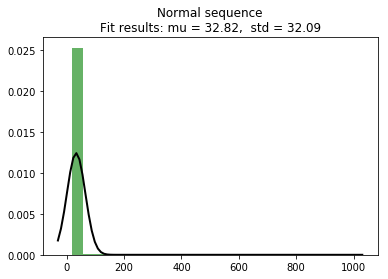

280/280 [==============================] - 0s 2ms/step


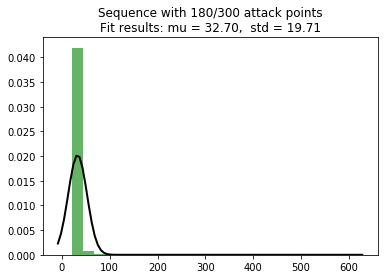

280/280 [==============================] - 0s 2ms/step


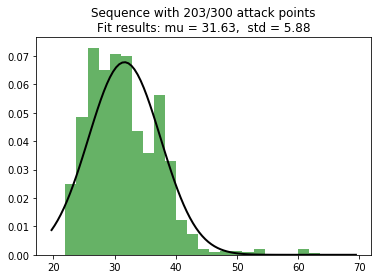

280/280 [==============================] - 1s 2ms/step


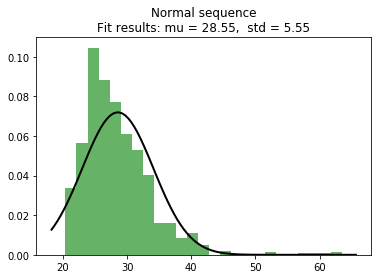

280/280 [==============================] - 1s 2ms/step


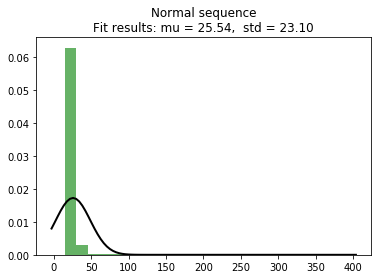

280/280 [==============================] - 1s 2ms/step


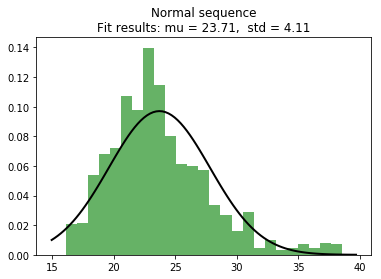

280/280 [==============================] - 1s 2ms/step


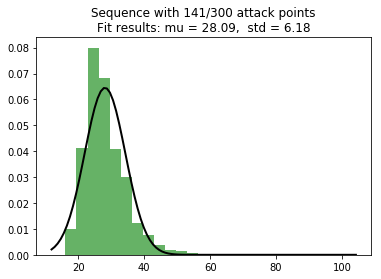

280/280 [==============================] - 0s 2ms/step


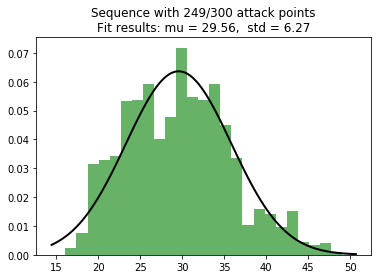

280/280 [==============================] - 1s 2ms/step


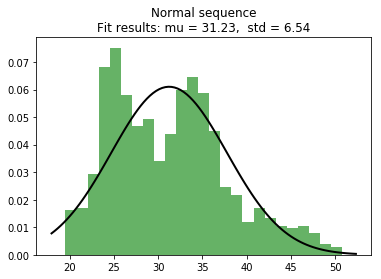

280/280 [==============================] - 1s 2ms/step


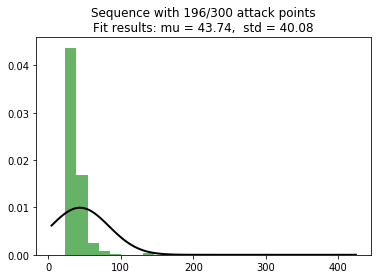

280/280 [==============================] - 1s 2ms/step


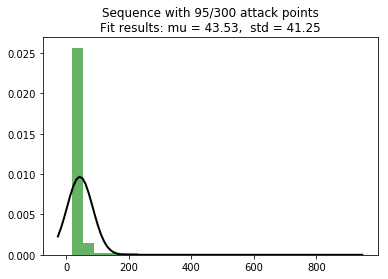

280/280 [==============================] - 1s 2ms/step


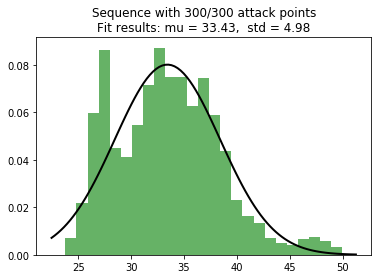

280/280 [==============================] - 1s 2ms/step


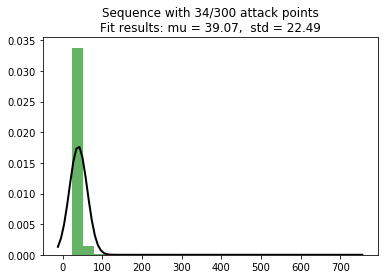

280/280 [==============================] - 1s 2ms/step


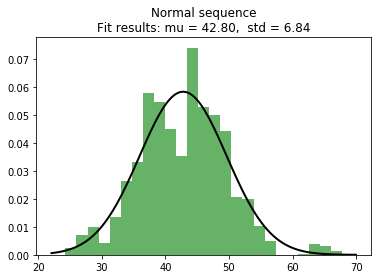

280/280 [==============================] - 1s 2ms/step


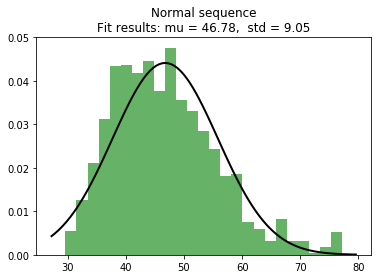

280/280 [==============================] - 1s 2ms/step


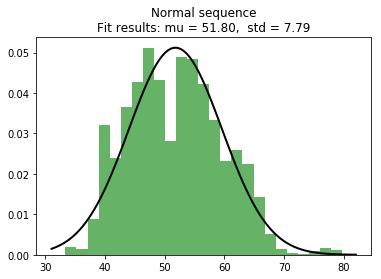

280/280 [==============================] - 0s 2ms/step


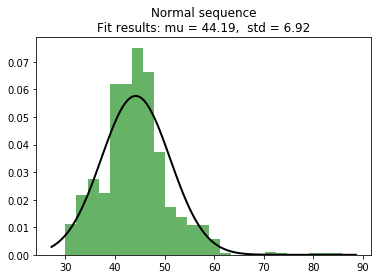

280/280 [==============================] - 1s 2ms/step


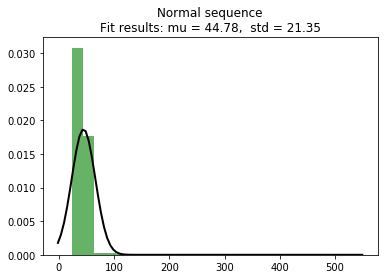

280/280 [==============================] - 1s 2ms/step


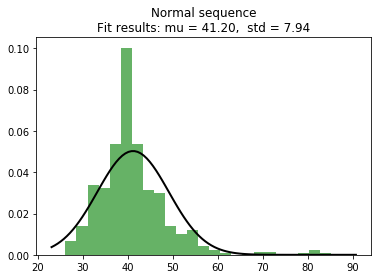

280/280 [==============================] - 0s 2ms/step


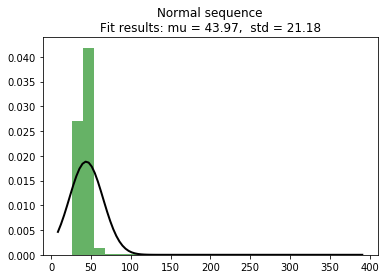

280/280 [==============================] - 0s 2ms/step


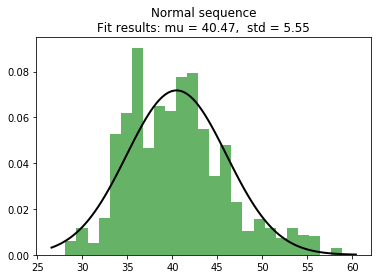

280/280 [==============================] - 0s 2ms/step


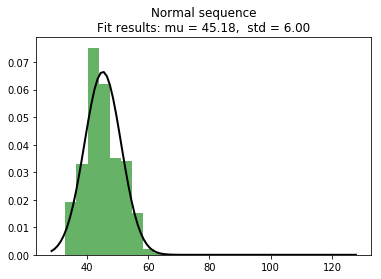

280/280 [==============================] - 1s 2ms/step


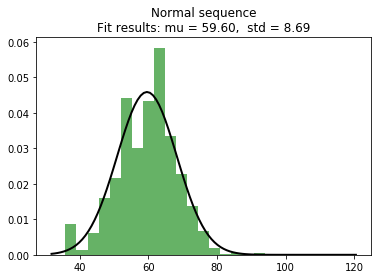

280/280 [==============================] - 1s 2ms/step


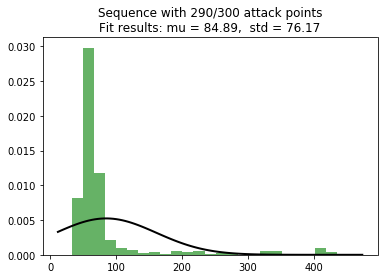

280/280 [==============================] - 1s 2ms/step


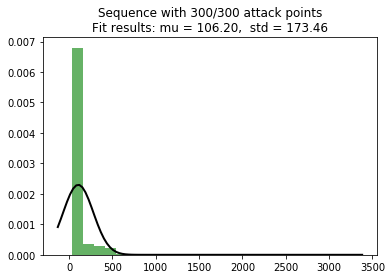

280/280 [==============================] - 1s 2ms/step


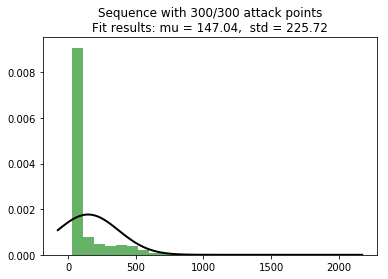

280/280 [==============================] - 1s 2ms/step


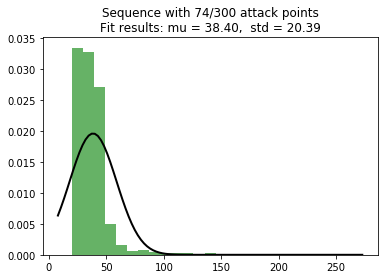

280/280 [==============================] - 1s 2ms/step


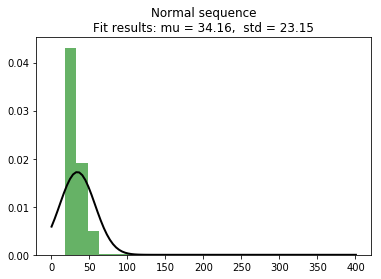

280/280 [==============================] - 1s 2ms/step


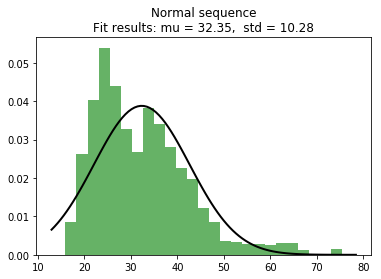

280/280 [==============================] - 0s 2ms/step


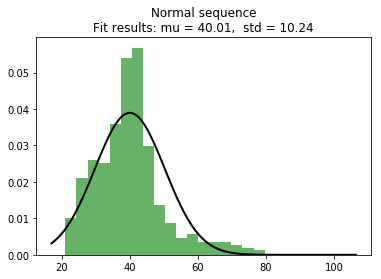

280/280 [==============================] - 1s 2ms/step


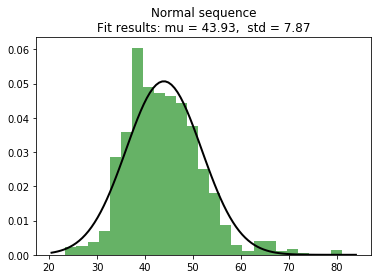

280/280 [==============================] - 0s 2ms/step


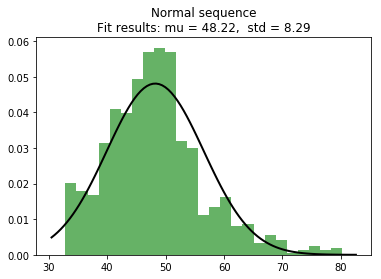

280/280 [==============================] - 0s 2ms/step


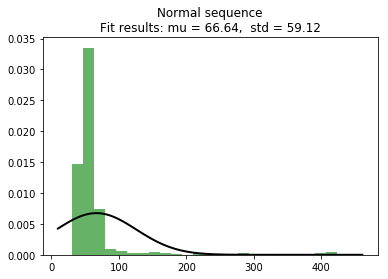

280/280 [==============================] - 0s 2ms/step


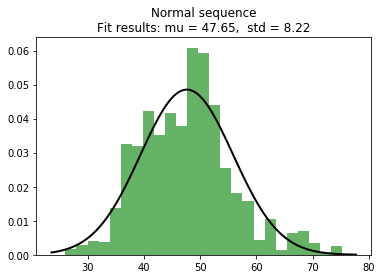

280/280 [==============================] - 0s 2ms/step


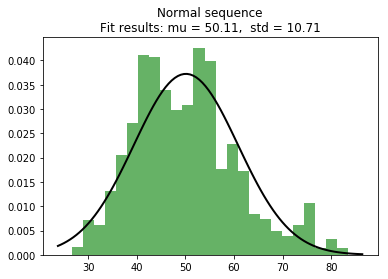

280/280 [==============================] - 1s 2ms/step


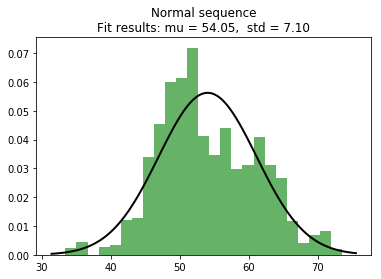

280/280 [==============================] - 1s 2ms/step


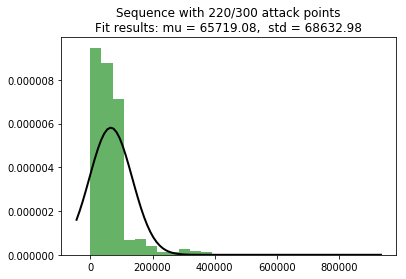

280/280 [==============================] - 1s 2ms/step


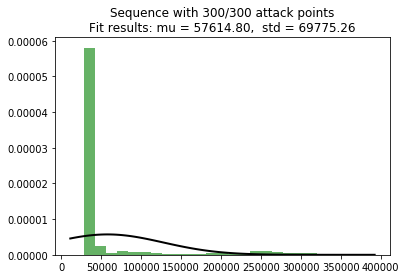

280/280 [==============================] - 1s 2ms/step


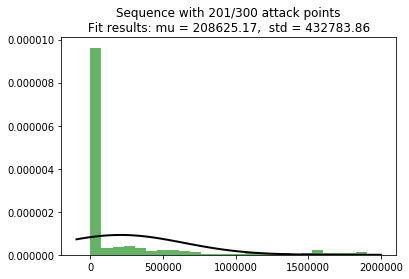

280/280 [==============================] - 1s 2ms/step


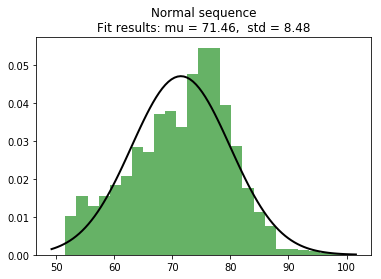

280/280 [==============================] - 1s 2ms/step


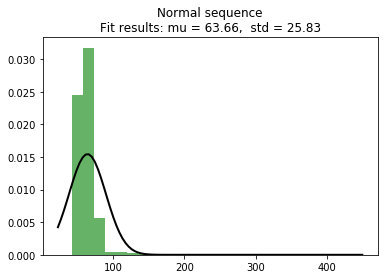

280/280 [==============================] - 0s 2ms/step


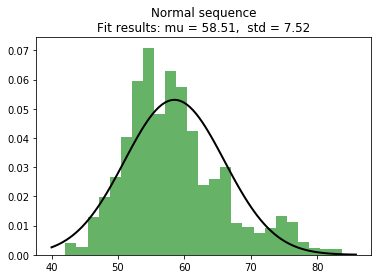

280/280 [==============================] - 1s 2ms/step


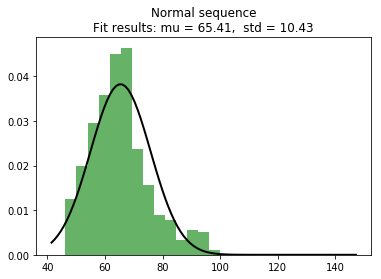

280/280 [==============================] - 0s 2ms/step


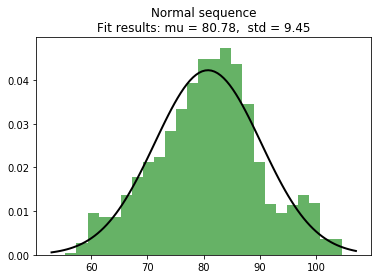

280/280 [==============================] - 0s 2ms/step


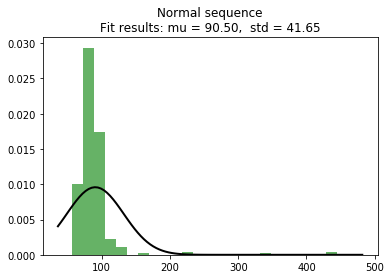

280/280 [==============================] - 0s 2ms/step


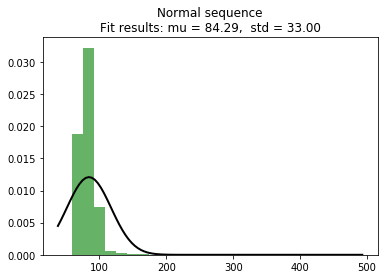

280/280 [==============================] - 1s 2ms/step


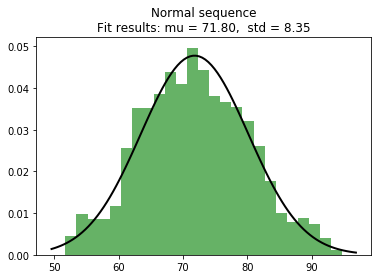

280/280 [==============================] - 0s 2ms/step


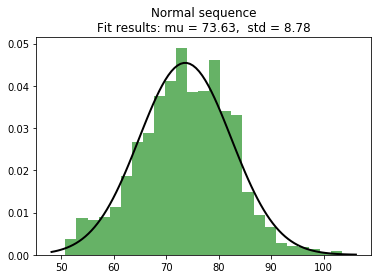

280/280 [==============================] - 1s 2ms/step


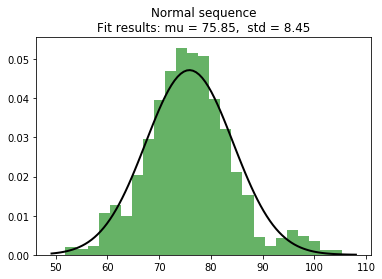

280/280 [==============================] - 1s 2ms/step


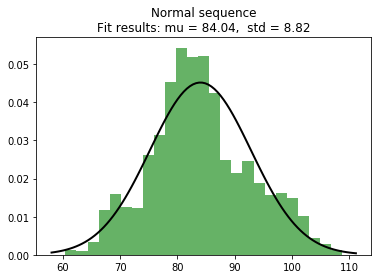

280/280 [==============================] - 1s 2ms/step


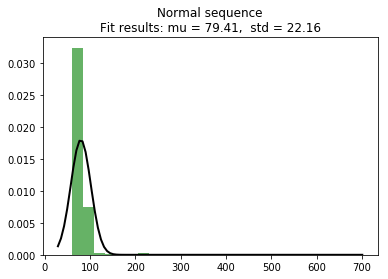

In [64]:
for s in anom_dataset:
    title = ""
    if 'Attack' in s:
        attack_counts = np.count_nonzero('Attack' == s)
        title = "Sequence with " + str(attack_counts) + "/300 attack points"
    else:
        title = "Normal sequence"
    _= sequence_scores(s,  title=title, plot=True)    